![CDS 411 logo](../../img/cds-411-logo.png)

# Cellular automata III: Ants

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML

rc("animation", html="html5")

np.random.seed(11897733)

## Initializing the System

In [2]:
def init_ants(n, prob_ant):
    """Initialize an n ⨉ n grid of ants.
    
    Parameters
    ----------
    n : int
        Number of rows and columns in the grid

    prob_tree : float
        Probability to initialize a cell with an ant
        
    Returns
    -------
    ants : np.array
        Grid of integers defining the ant population
    """
    ants = np.zeros(shape=(n, n), dtype=np.int)

    ant_cells = np.random.uniform(low=0, high=1, size=(n, n)) < prob_ant
    number_ants = np.sum(ant_cells)

    ants[ant_cells] = np.random.randint(low=1, high=5, size=number_ants)

    return ants

In [3]:
def init_pheromones(n, max_pheromone, trail_length, trail_start):
    """Initialize an n ⨉ n grid of pheromones.
    
    Parameters
    ----------
    n : int
        Number of rows and columns in the grid

    max_pheromone : float
    
    trail_length : int
    
    trail_start : list-like
        
    Returns
    -------
    pheromones : np.array
        Grid of floats defining the ant pheromones
    """
    pheromones = np.zeros(shape=(n, n), dtype=np.float)

    trail_row = trail_start[0]
    trail_start_column = trail_start[1]
    trail_end_column = trail_start[1] + trail_length
    
    pheromones[trail_row, trail_start_column:trail_end_column] = np.linspace(
        start=0,
        stop=max_pheromone,
        num=trail_end_column - trail_start_column)
    
    return pheromones

Let's test that the above function creates the ants and pheromones grids, assuming that we have a 17 ⨉ 17 grid, a 10% chance that any given cell starts with an ant, and that a pheromone trail is laid down in the center row of the grid with values linearly increasing from 0 to 50 when going from the first column to the last column.

In [4]:
ants = init_ants(17, 0.1)
pheromones = init_pheromones(17, 50, 17, [8, 0])

To inspect that the grids were constructed correctly, we will utilize a heat map visualization.
For the ant grid, empty squares will be black, squares with ants will be orange, and border squares (not yet defined) will be gray.
For the pheromones grid, we apply the *viridis* colormap scheme.

In [5]:
def visualize_grid(grid, grid_type, fig_width=6, fig_height=6, dpi=120):
    """Visualize a 2D numpy array using a heatmap.

    Parameters
    ----------
    grid : np.array
        A two-dimensional array representing the cellular automata grid
        
    grid_type : str
        Sets the appropriate colormap by using 'discrete' or 'continuous'
    
    fig_width : float
        Figure width in inches
        
    fig_height : float
        Figure height in inches
        
    Returns
    -------
    fig, ax : tuple of plt.figure and plt.subplot
        Matplotlib figure and subplot axis objects
        
    .. _colormaps: https://matplotlib.org/examples/color/colormaps_reference.html 
    """
    # grid dimensions
    m, n = grid.shape

    # create matplotlib figure and subplot objects
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    # Define a custom color map, with 0 being black, 1 being tab:blue, and
    # 2 being tab:orange
    # imshow visualizes array as a two-dimensionl uniform grid
    if grid_type == "discrete":
        cmap = LinearSegmentedColormap.from_list(
            'ants', ['black', 'tab:orange', 'tab:orange', 'tab:orange',
                     'tab:orange', 'tab:orange', 'gray'])
        im = ax.imshow(grid, cmap=cmap, interpolation="nearest", vmin=0,
                       vmax=6)
    elif grid_type == "continuous":
        cmap = "viridis"
        im = ax.imshow(grid, cmap=cmap, interpolation="nearest")

    # find the starting and ending coordinates for heatmap for creating
    # grid lines
    xticks_start, xticks_end = ax.get_xlim();
    yticks_start, yticks_end = ax.get_ylim();

    # separate grid cells by white lines
    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1),
                       minor=False);
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1),
                       minor=False);
    ax.axes.grid(True, linestyle="-", linewidth=0.3, color="white",
                 which="major");
    
    # we don't need ticks and tick labels because we have grid lines
    ax.tick_params(labelbottom = False, labelleft=False, bottom=False,
                   left=False);
    
    # Return matplotlib figure and subplot objects
    return fig, ax

So, for our example, we get the following heatmap for the ants grid:

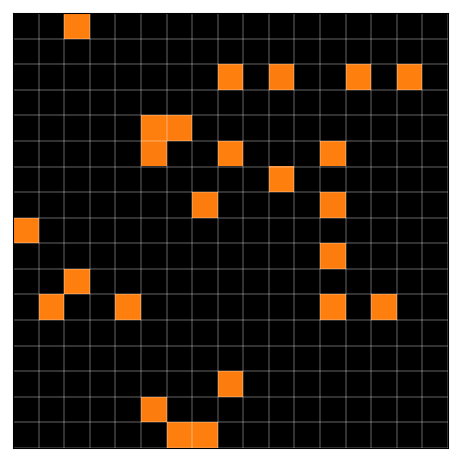

In [6]:
visualize_grid(ants, "discrete", dpi=96);

And we get the following heatmap for the pheromones grid:

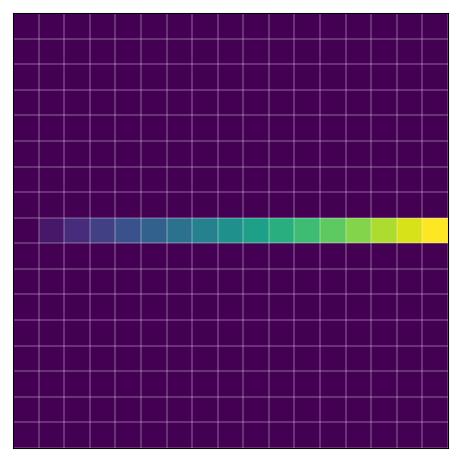

In [7]:
visualize_grid(pheromones, "continuous", dpi=96);

This is exactly what we expected to see.

## Boundary Conditions

For the ants, we will implement **absorbing boundary conditions** using the standard **ghost cells** approach.
The following function sets up the ghost cells in `numpy`:

In [8]:
def boundary_condition(grid, constant_values, condition="absorbing"):
    """Wrap grid with ghost cells for boundary condition.
    
    Parameters
    ----------
    grid : np.array
        2D Grid of integers or floats
        
    condition : str, optional
        The boundary condition to use when creating ghost cells.
    """
    if condition == "absorbing":
        grid_with_border = np.pad(
            array=grid, pad_width=(1, 1), mode='constant',
            constant_values=constant_values)

    else:
        raise ValueError(
            "{0} is not a valid boundary condition".format(condition))

    return grid_with_border

Let's test that the ghost cells work as expected.
We wish to wrap the `ants` grid with cells equal to `6`, which indicates the presence of a border.
We also wish to wrap the `pheromones` grid with cells equal to `-0.01`, which will prevent ants from entering a border cell.

In [9]:
ants_extended = boundary_condition(ants, constant_values=6)
pheromones_extended = boundary_condition(pheromones, constant_values=-0.01)

To check that it worked, we visualize the ants grid with a border:

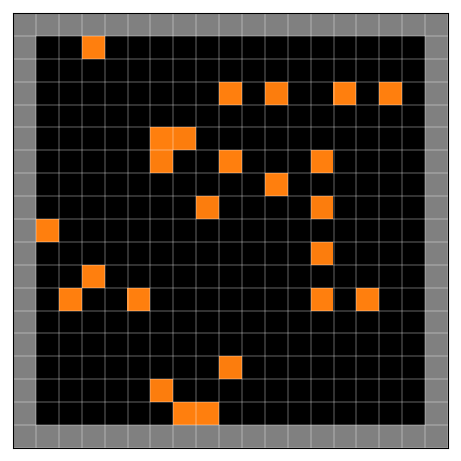

In [10]:
visualize_grid(ants_extended, "discrete", dpi=96);

And we also visualize the pheromones grid:

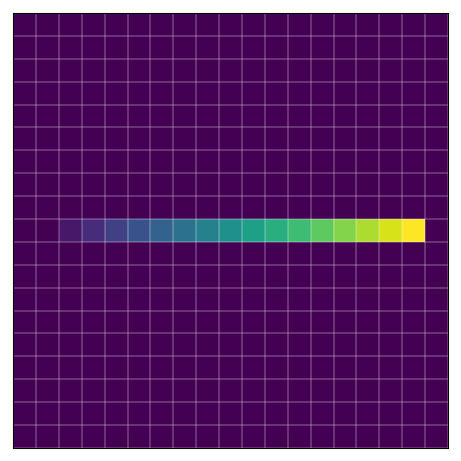

In [11]:
visualize_grid(pheromones_extended, "continuous", dpi=96);

## Finding neighbors

This simulation makes use of both the **Moore neighborhood** and the **von Neumann neighborhood**, with the diffusion of pheromones using **Moore** and an ant's sensing and walking stages using **von Neumann**.
We define a function that allows us to return both kinds of neighborhoods:

In [12]:
def get_neighbors(extended_grid,
                  neighborhood,
                  ghost_width=(1, 1)):
    """Get the cellular state of each site's neighbors in a single sweep.
    
    Paramters
    ---------
    extended_grid : np.array
        Grid defining states in a cellular automata simulation
        
    neighborhood : str, optional
        Determines which cells will be counted as neighbors, set to either
        'moore' or 'von_neumann'
        
    ghost_width : array-like, optional
        A number pair that specifies how many rows and columns make up the
        ghost cell region
        
    Returns
    -------
    grid_with_neighbors : np.array
        Grid containing the states of each cell's neighbors
    """
    m_extended, n_extended = extended_grid.shape
    m, n = (m_extended - ghost_width[0], n_extended - ghost_width[1])
    
    if neighborhood == "von_neumann":
        grid_with_neighbors = np.array([
            np.roll(
                extended_grid, shift=(0, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(-1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(0, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n]])

    elif neighborhood == "moore":
        grid_with_neighbors = np.array([
            np.roll(
                extended_grid, shift=(1, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(0, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(-1, 1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(-1, 0),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(-1, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(0, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n],
            np.roll(
                extended_grid, shift=(1, -1),
                axis=(1, 0))[ghost_width[0]:m, ghost_width[1]:n]])

    else:
        raise ValueError(
            "{0} is not a valid type of neighborhood".format(neighborhood))

    return grid_with_neighbors

## Diffusion of pheromones

In [13]:
def diffusion(grid, neighbors, diffusion_rate):
    """Diffuse cells in grid for a single time step.
    
    Parameters
    ----------
    grid : np.array

    grid_neighbors : np.array
        An array of temperatures for each site and its neighbors

    diffusion_rate : float
        Sets ease of flow from high to low value cells in grid
        
    Returns
    -------
    grid_update : np.array
        Updated grid after applying diffusion to all cells
    """
    num_neighbors, m, n = neighbors.shape
    
    grid_update = (
        (1 - num_neighbors * diffusion_rate) * grid +
        diffusion_rate * np.sum(a=neighbors, axis=0))
    grid_update[grid_update < 0] = 0

    return grid_update

## Ant Movement

Moving the ants around the grid occurs in two stages:

1.  Sensing stage: the ants sense the pheromones in the neighboring cells and change the direction they're facing
2.  Walking stage: the ants move on the grid according to the direction selected in the sensing stage

There are a set of rules governing each stage.

### Sensing stage

During the sensing stage, the ants update their state according to the following rules:

1.  An empty cell does not point toward any direction
2.  An ant does not turn to a cell from which the creature just came
3.  An ant does not turn to a location that is a border site
4.  An ant does not turn to a location that currently contains an ant
5.  Otherwise, an ant turns in the direction of the neighboring available cell (not the previous, an occupied, or a border cell) with the greatest amount of chemical pheromone.
    In the case of more than one neighbor having the maximum amount, the ant turns at random towards one of these cells.
6.  If no neighboring cell is available, the ant will not move

In [14]:
def sense_find_ants(ants, ants_neighbors, pheromones_neighbors):
    m, n = ants.shape
    previous_ants_state = ants.copy()
    II, JJ = np.meshgrid(
        np.arange(m), np.arange(n), indexing='ij')
    ant_cells = np.logical_and(ants != 0, ants != 6)
    ants_ij = np.column_stack((II[ant_cells], JJ[ant_cells]))
    
    return previous_ants_state, ants_ij

In [15]:
def sense_no_backtrack(ants, pheromones_neighbors, ij):
    map_van_neumann_to_moore = {1: 1, 2: 4, 3: 6, 4: 3}
    ant_state = ants[ij[0], ij[1]]
        
    if ant_state != 5:
        pheromones_direction = map_van_neumann_to_moore[ant_state]
        pheromones_neighbors[pheromones_direction, ij[0], ij[1]] = -2

In [16]:
def sense_detect_neighbors(ants, ants_neighbors, pheromones_neighbors, ij):
    map_van_neumann_to_moore = {1: 1, 2: 4, 3: 6, 4: 3}
    for direction, ant_neighbor in enumerate(ants_neighbors, start=1):
        check_neighbor = ant_neighbor[ij[0], ij[1]]
        ant_present = check_neighbor != 0
        if ant_present:
            pheromones_direction = map_van_neumann_to_moore[direction]
            pheromones_neighbors[pheromones_direction, ij[0], ij[1]] = -2

In [17]:
def sense_detect_pheromones(pheromones_neighbors, ij):
    pheromone_sense_list = np.array([
       [1, pheromones_neighbors[1, ij[0], ij[1]]],
       [2, pheromones_neighbors[4, ij[0], ij[1]]],
       [3, pheromones_neighbors[6, ij[0], ij[1]]],
       [4, pheromones_neighbors[3, ij[0], ij[1]]]
    ])
    
    return pheromone_sense_list

In [18]:
def sense_choose_direction(pheromone_sense_list):
    nesw_ant_directions = pheromone_sense_list[:, 0]
    maximum_value = np.max(pheromone_sense_list[:, 1])
    rows_containing_maximum_value = (
        np.isclose(maximum_value, pheromone_sense_list[:, 1]))
    directions_to_choose_from = (
        nesw_ant_directions[rows_containing_maximum_value])
    update_state = (
        directions_to_choose_from
        if directions_to_choose_from.shape[0] == 1
        else np.random.choice(directions_to_choose_from))
    
    return np.int(update_state)

In [19]:
def sense(ants, ants_neighbors, pheromones_neighbors):
    previous_ants_state, ants_ij = (
        sense_find_ants(ants, ants_neighbors, pheromones_neighbors))
    
    for ij in ants_ij:
        sense_no_backtrack(ants, pheromones_neighbors, ij)
        sense_detect_neighbors(ants, ants_neighbors, pheromones_neighbors, ij)
            
        pheromone_sense_list = sense_detect_pheromones(pheromones_neighbors, ij)
        all_negative_pheromones_test = np.all(pheromone_sense_list < 0)
        
        if all_negative_pheromones_test:
            update_state = 5
        else:
            update_state = sense_choose_direction(pheromone_sense_list)
            
        ants[ij[0], ij[1]] = update_state

### Walking stage

After the sensing stage, the ants will then walk.
The pheromone grid will also receive an update prior to running the diffusion step.
The rules are as follows:

1.  For a cell that remains empty, the amount of chemical pheromone decrements by a constant amount `evaporate`, but does not fall below 0.
    Thus, the new amount is the maximum of 0 and the current amount minus `evaporate`.
2.  An ant facing in a certain direction will move into that neighboring cell as long as no other ant has already moved there
3.  Otherwise, the ant will stay in its current cell
4.  If an ant leaves a cell that has pheromone above a certain threshold, `threshold`, the amount of chemical pheromone increments by a set amount, `deposit`, to reinforce the trail
5.  If an ant stays in a cell, the amount of chemical remains the same
6.  After moving to a new location, the ant faces towards the cell from which the animal just came

In [20]:
def walk_find_ants(extended_ants):
    m, n = extended_ants.shape
    previous_ants_state = extended_ants.copy()
    II, JJ = np.meshgrid(
        np.arange(m), np.arange(n), indexing='ij')
    moving_ant_cells = (
        np.logical_and(extended_ants != 0, np.logical_and(extended_ants != 5, extended_ants != 6)))
    extended_ants_ij = np.column_stack((II[moving_ant_cells], JJ[moving_ant_cells]))
    np.random.shuffle(extended_ants_ij)
    
    return previous_ants_state, extended_ants_ij

In [21]:
def evaporate_pheromones(ants, previous_ants_state, pheromones, evaporate):
    cells_remained_empty = np.logical_and(previous_ants_state == 0, ants == 0)
    number_remaining_empty = np.sum(cells_remained_empty)
    pheromones[cells_remained_empty] -= evaporate
    pheromones[cells_remained_empty] = (
        np.maximum(np.zeros(number_remaining_empty),
                   pheromones[cells_remained_empty]))

In [22]:
def deposit_pheromone(pheromones, ij, threshold, deposit):
    if pheromones[ij[0], ij[1]] > threshold:
        pheromones[ij[0], ij[1]] += deposit

In [23]:
def movement(ant_state, ij):
    if ant_state == 1:
        update_ij = ij + np.array([-1, 0])
    elif ant_state == 2:
        update_ij = ij + np.array([0, 1])
    elif ant_state == 3:
        update_ij = ij + np.array([1, 0])
    elif ant_state == 4:
        update_ij = ij + np.array([0, -1])
    else:
        raise ValueError(
            "{0} is not a valid ant state".format(ant_state))
        
    return update_ij

In [24]:
def turn_around(ant_state):
    if ant_state == 1:
        new_state = 3
    elif ant_state == 2:
        new_state = 4
    elif ant_state == 3:
        new_state = 1
    elif ant_state == 4:
        new_state = 2
    else:
        raise ValueError(
            "{0} is not a valid ant state".format(ant_state))
        
    return new_state

In [25]:
def walk(ants, pheromones, evaporate, threshold, deposit):
    """Update the ants and pheromones grids based on sensing step.
    
    """
    extended_ants = boundary_condition(ants, 6, condition="absorbing")
    extended_pheromones = boundary_condition(pheromones, -0.01, condition="absorbing")
    previous_ants_state, ants_ij = walk_find_ants(extended_ants)

    for ij in ants_ij:
        ant_state = extended_ants[ij[0], ij[1]]
        update_ij = movement(ant_state, ij)
        neighboring_block = extended_ants[update_ij[0], update_ij[1]]
        ant_blocking_move = neighboring_block != 0 & neighboring_block != 6

        if ant_blocking_move:
            extended_ants[ij[0], ij[1]] = 5
        else:
            extended_ants[ij[0], ij[1]] = 0
            deposit_pheromone(extended_pheromones, ij, threshold, deposit)
            extended_ants[update_ij[0], update_ij[1]] = turn_around(ant_state)

    evaporate_pheromones(extended_ants, previous_ants_state, extended_pheromones, evaporate)
    m, n = extended_ants.shape
    ants[:, :] = extended_ants[1:(m - 1), 1:(n - 1)]
    pheromones[:, :] = extended_pheromones[1:(m - 1), 1:(n - 1)]

Now we sweep over all lattice points.
In addition to the spread routine defined above, we also append the updated grid to the `simulation_history` list so that we can animate the diffusion simulation.

## Define a full time step

Now we combine all our previous functions to define a single time step for the ants simulation:

In [26]:
def time_step(ants, pheromones, evaporate, threshold, deposit, diffusion_rate,
              nstep, simulation_history):
    """Execute a time step and update the ants and pheromones grids.
    
    Parameters
    ----------
    ants : np.array
    
    pheromones : np.array
    
    max_pheromones : float
    
    evaporate : float
    
    threshold : float
    
    deposit : float
    
    nstep : int
        The current time step number for the simulation

    simulation_history : list
        Time-step history for the simulation's run.
    """
    extended_ants = boundary_condition(ants, constant_values=6)
    extended_pheromones = boundary_condition(
        pheromones, constant_values=-0.01)
    ants_neighbors = get_neighbors(
        extended_ants, neighborhood="von_neumann")
    pheromones_neighbors = get_neighbors(
        extended_pheromones, neighborhood="moore")

    sense(ants, ants_neighbors, pheromones_neighbors)
    walk(ants, pheromones, evaporate, threshold, deposit)
    pheromones[:, :] = diffusion(
        pheromones, pheromones_neighbors, diffusion_rate)
    
    simulation_history.append([nstep, ants.copy(), pheromones.copy()])

## Simulation Program

Finally, we bring it all together into a function that runs the full simulation from start to finish.
This is where we put our `for` loop over time.

In [27]:
def ants_simulation(number_time_steps, n, prob_ant, max_pheromone,
                    trail_length, trail_start, evaporate, threshold, deposit,
                    diffusion_rate):
    """Run the ants simulation.
    
    Parameters
    ----------
    number_time_steps : int
        Sets the number of time steps over which to run a simulation.

    n : int
        Number of rows and columns in the grid

    prob_ant : float

    max_pheromone : float
    
    trail_length : int
    
    trail_start : list-like
    
    evaporate : float
    
    threshold : float
    
    deposit : float

    Returns
    -------
    simulation_history : list
    """
    # Initialize ants and pheromones according to parameters
    ants = init_ants(n, prob_ant)
    pheromones = init_pheromones(n, max_pheromone, trail_length, trail_start)

    # Initialize record keeper for the simulation history
    simulation_history = [[0, ants.copy(), pheromones.copy()]]

    # Run simulation for specified number of time steps
    for nstep in np.arange(number_time_steps):
        time_step(ants, pheromones, evaporate, threshold, deposit,
                  diffusion_rate, nstep, simulation_history) 

    return simulation_history

## Display Simulation

Having successfully run our simulation, now we would like to see it in action!
We advance each frame of the animation by incrementing the index on `simulation_history` by 1.

In [28]:
def ca_animation(simulation_history, fig_width=6, fig_height=6, dpi=120):
    """Animate the cellular automata simulation using Matplotlib.

    Parameters
    ----------
    simulation_history : list
        Time-step history for the simulation's run.
    
    cmap : str, optional
        Color scheme for the heatmap scale, see colormaps_ reference.
        
    fig_width : float, optional
        Figure width in inches
        
    fig_height : float, optional
        Figure height in inches
        
    Returns
    -------
    anim : matplotlib.animation.FuncAnimation
        Animated object for the simulation run.
        
    .. _colormaps: https://matplotlib.org/examples/color/colormaps_reference.html 
    """
    # grid dimensions
    m, n = simulation_history[0][1].shape

    # create matplotlib figure and subplot objects
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    # imshow visualizes array as a two-dimensionl uniform grid
    cmap = LinearSegmentedColormap.from_list(
        'ants', [(0, 0, 0, 0), 'tab:orange', 'tab:orange', 'tab:orange',
                 'tab:orange', 'tab:orange', 'gray'])
    cmap2 = "viridis"
    im2 = ax.imshow(simulation_history[0][2], cmap=cmap2, interpolation="nearest", vmin=0)
    im = ax.imshow(
        simulation_history[0][1], cmap=cmap,interpolation="nearest", alpha=0.8,
        vmin=0, vmax=6)

    # find the starting and ending coordinates for heatmap for creating
    # grid lines
    xticks_start, xticks_end = ax.get_xlim();
    yticks_start, yticks_end = ax.get_ylim();

    # separate grid cells by white lines
    ax.xaxis.set_ticks(np.linspace(xticks_start, xticks_end, n + 1),
                       minor=False);
    ax.yaxis.set_ticks(np.linspace(yticks_start, yticks_end, m + 1),
                       minor=False);
    ax.axes.grid(True, linestyle="-", linewidth=0.3, color="white",
                 which="major");
    
    # we don't need ticks and tick labels because we have grid lines
    ax.tick_params(labelbottom = False, labelleft=False, bottom=False,
                   left=False);
    
    # Initialization function, clears out the data on the im object
    def init():
        im2.set_array(np.array([[]]))
        im.set_array(np.array([[]]))
        return (im, im2, )


    # Animation function. Input i is the frame number of the animation, and is
    # to be used for referencing how the data changes over time
    def animate(i):
        # Get the simulation history at time step i and set as the underlying
        # data for the im object
        ants_i = simulation_history[i][1]
        pheromones_i = simulation_history[i][2]
        im2.set_array(pheromones_i)
        im.set_array(ants_i)

        return (im, im2, )

    # Suppress static matplotlib window
    plt.close()
    
    # Use animation.FuncAnimation to put the animation together.
    # frames controls the number of frames in the movie.
    # interval controls the delay in milliseconds inbetween each frame
    # blit optimizes the animation size by only storing the changes between
    # frames instead of as a series of full plots
    anim = animation.FuncAnimation(fig=fig, func=animate,
                                   frames=len(simulation_history),
                                   init_func=init, interval=500, blit=True);

    return anim

## Example Run

Now that all the pieces are in place, let's run the simulation with the following initial parameters, which match the parameters suggested in the textbook.

In [29]:
number_time_steps = 30
n = 17
prob_ant = 0.1
max_pheromone = 50
trail_length = 17
trail_start = [8, 0]
evaporate = 1
deposit = 2
threshold = 0
diffusion_rate = 0.01
simulation_history = ants_simulation(
    number_time_steps, n, prob_ant, max_pheromone,
    trail_length, trail_start, evaporate, threshold, deposit,
    diffusion_rate)

We then build our animation:

In [30]:
anim = ca_animation(simulation_history, dpi=120)

And view it:

In [ ]:
HTML(anim.to_html5_video())